## Code

In [2]:
## Importing packages 

import requests
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.sentiment import SentimentIntensityAnalyzer

from scipy.stats import chi2_contingency
from scipy.stats import alexandergovern


**Collecting the Data from Wikipedia** 

In [3]:
## Code referece: Week1.Day3.v01.Exercises-FSDS-MT2 (Hogen, 2023)

# See https://www.mediawiki.org/wiki/API:Revisions

def get_wikipedia_revisions(page_title: str, 
                            num_revisions:int = 500, 
                            rvstart="now",
                            oldest_first=False) -> list:
    base_url = 'https://en.wikipedia.org/w/api.php'
    
    
    params = {
        'action': 'query',
        'format': 'json',
        'titles': page_title,
        'prop': 'revisions',
        'rvprop': 'ids|timestamp|user|comment|content|size',
        'rvlimit': "max",
        'rvstart': rvstart,
    }
    if oldest_first:
        params['rvdir'] = 'newer'
   
    revisions = []
    continue_token = True

    while continue_token and (len(revisions) <= num_revisions):
        response = requests.get(url=base_url, params=params)
        
        data = response.json()

        page_id = next(iter(data['query']['pages']))
        revisions.extend(data['query']['pages'][page_id]['revisions']) # 
        
        print(f"Currently collecting revision #{len(revisions)}")
        
        continue_token = 'continue' in data
        if continue_token:
            params['rvcontinue'] = data['continue']['rvcontinue']

    return revisions

In [4]:
## Data collected Dec 5th, 2023 at 3:06 pm 
## Data was saved into an excel sheet so it didn't have to be collected over and over again

JSO = get_wikipedia_revisions(page_title = "Just Stop Oil", 
                              num_revisions = 2000)

Currently collecting revision #50
Currently collecting revision #100
Currently collecting revision #150
Currently collecting revision #200
Currently collecting revision #250
Currently collecting revision #300
Currently collecting revision #350
Currently collecting revision #400
Currently collecting revision #450
Currently collecting revision #500
Currently collecting revision #550
Currently collecting revision #600
Currently collecting revision #650
Currently collecting revision #700
Currently collecting revision #750
Currently collecting revision #800
Currently collecting revision #810


In [6]:
df_JSO = pd.DataFrame(JSO)
## df_JSO.to_excel("df_JSO.xlsx")

In [7]:
BP = get_wikipedia_revisions(page_title = "BP", 
                              num_revisions = 2000)

Currently collecting revision #46
Currently collecting revision #93
Currently collecting revision #140
Currently collecting revision #187
Currently collecting revision #235
Currently collecting revision #283
Currently collecting revision #332
Currently collecting revision #382
Currently collecting revision #432
Currently collecting revision #481
Currently collecting revision #531
Currently collecting revision #581
Currently collecting revision #631
Currently collecting revision #681
Currently collecting revision #731
Currently collecting revision #781
Currently collecting revision #831
Currently collecting revision #881
Currently collecting revision #931
Currently collecting revision #981
Currently collecting revision #1031
Currently collecting revision #1081
Currently collecting revision #1131
Currently collecting revision #1181
Currently collecting revision #1231
Currently collecting revision #1281
Currently collecting revision #1331
Currently collecting revision #1381
Currently coll

In [8]:
df_BP = pd.DataFrame(BP)
## df_BP.to_excel("df_BP.xlsx")

C:\Users\schoo\anaconda3\lib\site-packages\xlsxwriter\worksheet.py:1216: UserWarning: Ignoring URL since it exceeds Excel's string limit of 32767 characters
  warn(


In [9]:
Shell = get_wikipedia_revisions(page_title = "Shell plc", 
                              num_revisions = 2000)

Currently collecting revision #50
Currently collecting revision #100
Currently collecting revision #150
Currently collecting revision #200
Currently collecting revision #250
Currently collecting revision #300
Currently collecting revision #350
Currently collecting revision #400
Currently collecting revision #450
Currently collecting revision #500
Currently collecting revision #550
Currently collecting revision #600
Currently collecting revision #650
Currently collecting revision #700
Currently collecting revision #750
Currently collecting revision #800
Currently collecting revision #850
Currently collecting revision #900
Currently collecting revision #950
Currently collecting revision #1000
Currently collecting revision #1050
Currently collecting revision #1100
Currently collecting revision #1150
Currently collecting revision #1200
Currently collecting revision #1250
Currently collecting revision #1300
Currently collecting revision #1350
Currently collecting revision #1400
Currently co

In [10]:
df_Shell = pd.DataFrame(Shell)
## df_Shell.to_excel("df_Shell.xlsx")

In [118]:
GP = get_wikipedia_revisions(page_title = "Greenpeace", 
                              num_revisions = 2000)


Currently collecting revision #50
Currently collecting revision #100
Currently collecting revision #150
Currently collecting revision #200
Currently collecting revision #250
Currently collecting revision #300
Currently collecting revision #350
Currently collecting revision #400
Currently collecting revision #450
Currently collecting revision #500
Currently collecting revision #550
Currently collecting revision #600
Currently collecting revision #650
Currently collecting revision #700
Currently collecting revision #750
Currently collecting revision #800
Currently collecting revision #850
Currently collecting revision #900
Currently collecting revision #950
Currently collecting revision #1000
Currently collecting revision #1050
Currently collecting revision #1100
Currently collecting revision #1150
Currently collecting revision #1200
Currently collecting revision #1250
Currently collecting revision #1300
Currently collecting revision #1350
Currently collecting revision #1400
Currently co

In [120]:
df_GP = pd.DataFrame(GP)
## df_GP.to_excel("df_GP.xlsx")

**Finding the Number of Edits per Month** 

In [3]:
## Uploading the data 
df_JSO = pd.read_excel("df_JSO.xlsx")
df_GP = pd.read_excel("df_GP.xlsx")
df_BP = pd.read_excel("df_BP.xlsx")
df_Shell = pd.read_excel("df_Shell.xlsx")

In [4]:
## Code Reference: https://stackoverflow.com/questions/62788293/create-a-list-of-sequent-year-month-in-python

## Formatting dates in a way that will be easy to read on a plot

dates_formatted = pd.period_range('2011-01', freq = 'M', periods = 156).strftime('%Y - %m').tolist()
dates = pd.period_range('2011-01', freq = 'M', periods = 156).strftime('(%Y, %#m)').tolist()

In [5]:
## Creating empty data frame to store the number of edits per month in 

pre_data = {"dates" : dates_formatted,
           "JSO": np.zeros(len(dates_formatted)),
           "GP": np.zeros(len(dates_formatted)), 
            "BP": np.zeros(len(dates_formatted)),
            "Shell": np.zeros(len(dates_formatted))
           }

df_dates = pd.DataFrame(pre_data)


In [6]:
## Formatting the dates into a datetime.date type so that it will be easy to parse through 

df_JSO['dates'] = pd.to_datetime(df_JSO['timestamp']).dt.date
df_GP['dates'] = pd.to_datetime(df_GP['timestamp']).dt.date
df_BP['dates'] = pd.to_datetime(df_BP['timestamp']).dt.date
df_Shell['dates'] = pd.to_datetime(df_Shell['timestamp']).dt.date


## Code reference: https://stackoverflow.com/questions/29310116/removing-time-from-datetime-variable-in-pandas 
## Grouping the number of edits by year and month for every page

counts_JSO = df_JSO['dates'].groupby([pd.to_datetime(df_JSO["dates"]).dt.year, pd.to_datetime(df_JSO["dates"]).dt.month]).agg("count")
counts_GP =  df_GP['dates'].groupby([pd.to_datetime(df_GP["dates"]).dt.year, pd.to_datetime(df_GP["dates"]).dt.month]).agg("count")
counts_BP = df_BP['dates'].groupby([pd.to_datetime(df_BP["dates"]).dt.year, pd.to_datetime(df_BP["dates"]).dt.month]).agg("count")
counts_Shell = df_Shell['dates'].groupby([pd.to_datetime(df_Shell["dates"]).dt.year, pd.to_datetime(df_Shell["dates"]).dt.month]).agg("count")

In [7]:
## A function to go through the groupings and count how many edits per month and year there are

def count_edits_per_month(dates, df_dates, counts_agg, page_name): 
    
    index_val = 0

    for i in counts_agg: 
        if str(counts_agg.index[index_val] in dates):
            date_loc = dates.index(str(counts_agg.index[index_val]))
            df_dates.loc[date_loc, page_name] = i
        index_val = index_val + 1
        
    return df_dates
    

In [8]:
## Filling in the pre-defined data frame using count_edits_per_month() 

df_dates = count_edits_per_month(dates = dates, 
                                df_dates = df_dates, 
                                counts_agg = counts_JSO, 
                                page_name = "JSO")

df_dates = count_edits_per_month(dates = dates, 
                                df_dates = df_dates, 
                                counts_agg = counts_GP, 
                                page_name = "GP")

df_dates = count_edits_per_month(dates = dates, 
                                df_dates = df_dates, 
                                counts_agg = counts_BP, 
                                page_name = "BP")

df_dates = count_edits_per_month(dates = dates, 
                                df_dates = df_dates, 
                                counts_agg = counts_Shell, 
                                page_name = "Shell")

**Extra Information to Create First Table** 

In [9]:
## Finding the most recent page length 

print("JSO page length: " + str(len(df_JSO.loc[len(df_JSO) - 1, "*"])))
print("GP page length: " + str(len(df_GP.loc[len(df_GP) - 1, "*"])))
print("BP page length: " + str(len(df_BP.loc[len(df_BP) - 1, "*"])))
print("Shell page length: " + str(len(df_Shell.loc[len(df_Shell) - 1, "*"])))

JSO page length: 3385
GP page length: 32767
BP page length: 32767
Shell page length: 32767


In [10]:
## Finding the months with the most edits for every page 

print("JSO")
print(df_dates[df_dates["JSO"] == df_dates["JSO"].max()]["dates"])
print("")

print("BP")
print(df_dates[df_dates["BP"] == df_dates["BP"].max()]["dates"])
print("")

print("GP")
print(df_dates[df_dates["GP"] == df_dates["GP"].max()]["dates"])
print("")

print("Shell")
print(df_dates[df_dates["Shell"] == df_dates["Shell"].max()]["dates"])
print("")


JSO
141    2022 - 10
Name: dates, dtype: object

BP
88    2018 - 05
Name: dates, dtype: object

GP
98    2019 - 03
Name: dates, dtype: object

Shell
132    2022 - 01
Name: dates, dtype: object



In [11]:
## Finding how many edits there were in the most edited months 

print("JSO number of edits: ")
print(df_dates.loc[df_dates[df_dates["JSO"] == df_dates["JSO"].max()]["dates"].index[0], "JSO"])
print("")

print("GP number of edits: ")
print(df_dates.loc[df_dates[df_dates["GP"] == df_dates["GP"].max()]["dates"].index[0], "GP"])
print("")

print("BP number of edits: ")
print(df_dates.loc[df_dates[df_dates["BP"] == df_dates["BP"].max()]["dates"].index[0], "BP"])
print("")

print("Shell number of edits: ")
print(df_dates.loc[df_dates[df_dates["Shell"] == df_dates["Shell"].max()]["dates"].index[0], "Shell"])

JSO number of edits: 
217.0

GP number of edits: 
85.0

BP number of edits: 
71.0

Shell number of edits: 
86.0


**Plotting the Number of Edits over Time** 

In [12]:
## Creating a subset of the data the includes the most edits per month for every page

df_dates_subset = df_dates.loc[84:155]

In [27]:
## Plotting the number of edits over time for every page 

def plot1():

    fig = plt.figure(1, figsize=(18, 7)) 


    ax = sns.lineplot(
             x = "dates",
             y = "value",
            hue = "variable",
    data = pd.melt(df_dates_subset, ['dates']),
    palette = ['orange', 'green', 'blue', 'red'])

    ax.tick_params(axis='x', rotation = 75, labelsize = 14)
    ax.tick_params(axis='y', labelsize = 16)


    ax.set_ylabel("Number of Edits", fontsize = 20)
    ax.set_xlabel("Dates", fontsize = 20)
    ax.set_title("Number of Edits over Time", fontsize = 24)


    ax.legend(fontsize = 18)
    
    

**Range for analysis** 

In [30]:
## Creates a data frame for each page containing edits in 5 months 
## with the middle month being the one with the highest number of edits 

JSO_start = df_JSO[(pd.to_datetime(df_JSO["dates"]).dt.year == 2022) & (pd.to_datetime(df_JSO["dates"]).dt.month == 8)].index.max()
JSO_end = df_JSO[(pd.to_datetime(df_JSO["dates"]).dt.year == 2022) & (pd.to_datetime(df_JSO["dates"]).dt.month == 12)].index.min()
contro_JSO = df_JSO.loc[JSO_end:JSO_start].reset_index()


GP_start = df_GP[(pd.to_datetime(df_GP["dates"]).dt.year == 2019) & (pd.to_datetime(df_GP["dates"]).dt.month == 1)].index.max()
GP_end = df_GP[(pd.to_datetime(df_GP["dates"]).dt.year == 2019) & (pd.to_datetime(df_GP["dates"]).dt.month == 5)].index.min()
contro_GP = df_GP.loc[GP_end:GP_start].reset_index()


BP_start = df_BP[(pd.to_datetime(df_BP["dates"]).dt.year == 2019) & (pd.to_datetime(df_BP["dates"]).dt.month == 1)].index.max()
BP_end = df_BP[(pd.to_datetime(df_BP["dates"]).dt.year == 2019) & (pd.to_datetime(df_BP["dates"]).dt.month == 5)].index.min()
contro_BP = df_BP.loc[BP_end:BP_start].reset_index()


Shell_start = df_Shell[(pd.to_datetime(df_Shell["dates"]).dt.year == 2021) & (pd.to_datetime(df_Shell["dates"]).dt.month == 11)].index.max()
Shell_end = df_Shell[(pd.to_datetime(df_Shell["dates"]).dt.year == 2022) & (pd.to_datetime(df_Shell["dates"]).dt.month == 3)].index.min()
contro_Shell = df_Shell.loc[Shell_end:Shell_start].reset_index()


**Callouts**

In [31]:
## A function to find the number of reverts where people are called out

import re

def Count_Callouts(comment_series): 
    callout_count = 0
    
    for i in range(0, len(comment_series)): 
        
        if type(comment_series[i]) is not float: 
            
            if re.search("\[\[Special:", comment_series[i]): 
                callout_count = callout_count + 1
                
    return callout_count
    

In [32]:
## Finding the number of reverts where people are called out for each page

callout_JSO = Count_Callouts(contro_JSO["comment"])
callout_GP = Count_Callouts(contro_GP["comment"])
callout_BP = Count_Callouts(contro_BP["comment"])
callout_Shell = Count_Callouts(contro_Shell["comment"])

In [33]:
## Creating a data frame which normalises the number of callouts in the edits

df_callouts = pd.DataFrame({'Page': ['JSO', 'GP', 'BP', 'Shell'],
                   'Regular Edits': [(len(contro_JSO) -  callout_JSO) / len(contro_JSO),
                                     (len(contro_GP) -  callout_GP) / len(contro_GP),
                                     (len(contro_BP) -  callout_BP) / len(contro_BP),
                                     (len(contro_Shell) -  callout_Shell)/ len(contro_Shell)],
                   'Edits with Callouts': [callout_JSO / len(contro_JSO), 
                                          callout_GP / len(contro_GP),
                                          callout_BP / len(contro_BP),
                                          callout_Shell / len(contro_Shell)]})

In [37]:
## Plotting the proportion of edits with callouts 

## https://www.statology.org/seaborn-stacked-bar-plot/

def plot2(): 
    
    ax = df_callouts.set_index('Page').plot(kind = 'bar',
                                   stacked=True,
                                   color=['steelblue', 'red'])
    
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_title("Proportions of Edits with Callouts", fontsize = 12)
    ax.set_ylabel("Proportion", fontsize = 11)
    ax.set_xlabel("Page", fontsize = 11)
    ax.tick_params(axis = "both", labelsize = 11)



In [40]:
##  Creating a contingency table for the chi-square test
con_table = [[(len(contro_JSO) -  callout_JSO), 
              (len(contro_GP) -  callout_GP),
             (len(contro_BP) -  callout_BP),
             (len(contro_Shell) -  callout_Shell)], 
            [callout_JSO, callout_GP, callout_BP,
             callout_Shell]]

In [41]:
## Performing the chi-square test 

chi2_contingency(con_table).pvalue

3.5014640417319056e-11

**Negative Sentiment** 

In [42]:
## Finding the negative sentiment on every edited Wikipedia page during the 5-month range 

sia = SentimentIntensityAnalyzer()

neg_pages_JSO = contro_JSO["*"].map(lambda x: sia.polarity_scores(x)["neg"])
neg_pages_GP = contro_GP["*"].map(lambda x: sia.polarity_scores(x)["neg"])
neg_pages_BP = contro_BP["*"].map(lambda x: sia.polarity_scores(x)["neg"])
neg_pages_Shell = contro_Shell["*"].map(lambda x: sia.polarity_scores(x)["neg"])


In [43]:
## Creating a data frame with the negative sentiments for every page

neg_pages_df = pd.DataFrame({"JSO": neg_pages_JSO,
                            "GP": neg_pages_GP,
                            "BP": neg_pages_BP, 
                            "Shell": neg_pages_Shell})


## Melting the data frame to plot it using seaborn's boxplot

neg_pages_melted = pd.melt(neg_pages_df)
neg_pages_melted = neg_pages_melted.dropna()

In [46]:
## Plotting the negative sentiment from every page using barplots

def plot3():

    ax = sns.boxplot(data = neg_pages_melted, 
            x = "variable", 
            y = "value", 
            palette = ['orange', 'green', 'blue', 'red'])

    ax.set_title("Negative Sentiment on Wikipedia Pages during Most Edits", 
             fontsize = 12, loc = "center")
    ax.set_ylabel("Negative Sentiment", fontsize = 11)
    ax.set_xlabel("Pages", fontsize = 11)
    ax.tick_params(axis = 'both', labelsize = 11)


In [48]:
## Performing the Alexander Govern test	

alexandergovern(neg_pages_df["JSO"].dropna(),
          neg_pages_df["GP"].dropna(),
          neg_pages_df["BP"].dropna(),
          neg_pages_df["Shell"].dropna()).pvalue

0.0

## Essay 

**Checking** 

That everything is as it should be 

| Page | Current Page Length | Year and Month with Most Edits | Number of Edits | 
| :-: | :-: | :-: | :-: |
| JSO | 3385 | 2022 - 10 | 217 | 
| GP | 32767 | 2018 - 05 | 85 |
| BP | 32767 | 2019 - 03 | 71 |
| Shell | 32767 | 2022 - 01 | 86 |


| Measure of Controversy | Statistical Test | p-value | 
| :-: | :-: | :-: |
| Callout | Chi-square test | 3.5e-11 | 
| Negative Sentiment | Alexander Govern test | 0.0 | 



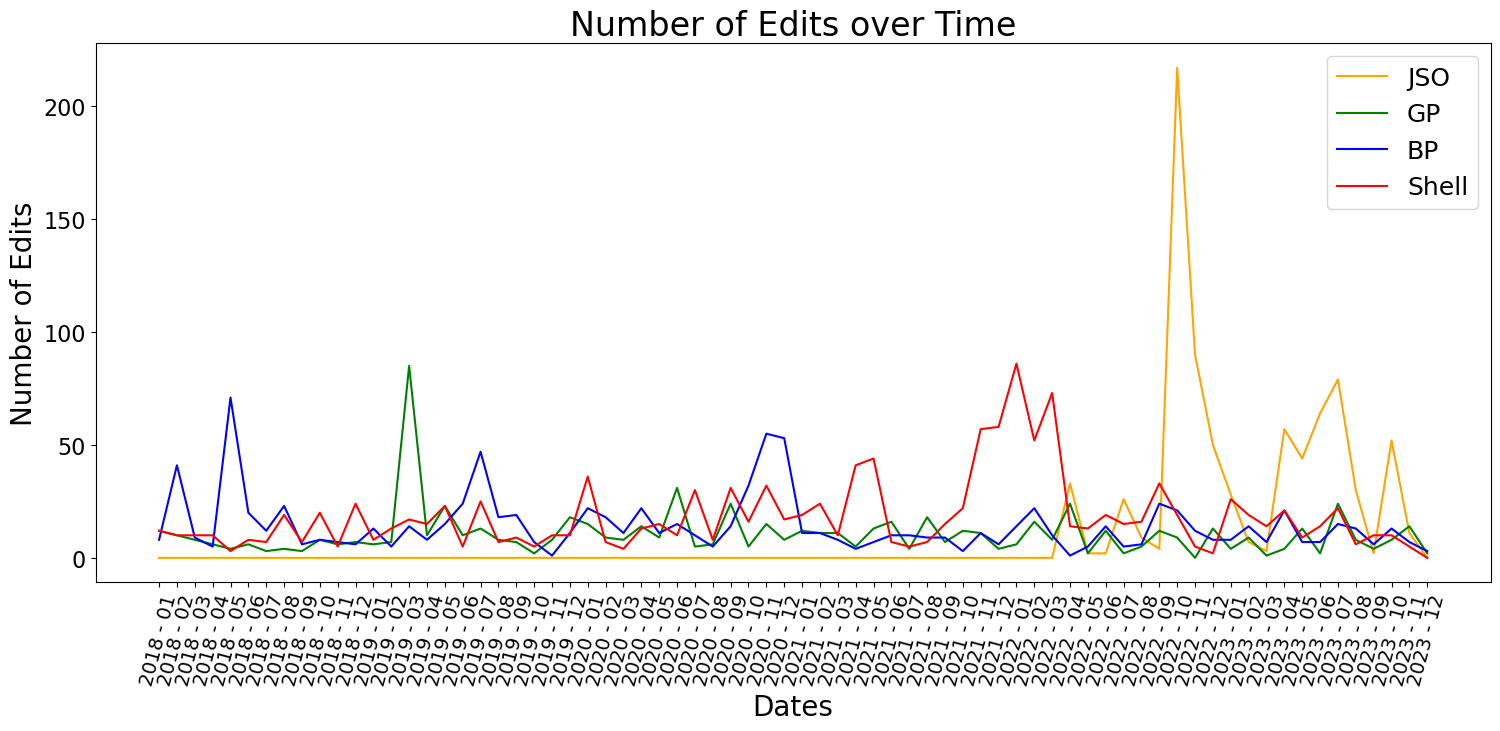

In [29]:
plot1()

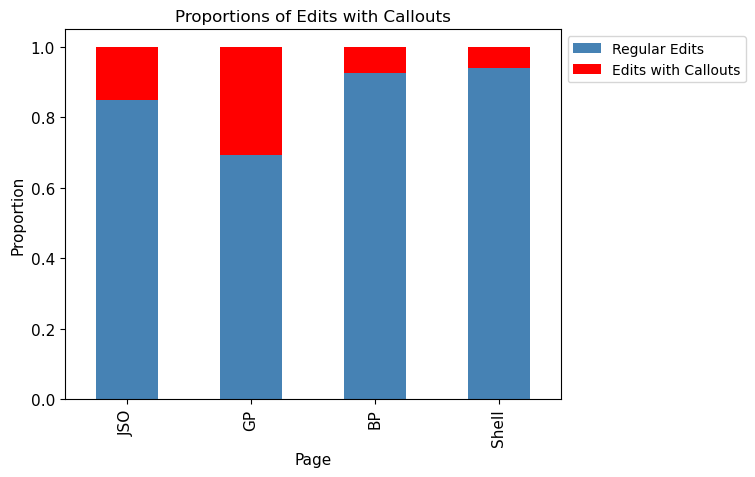

In [39]:
plot2()

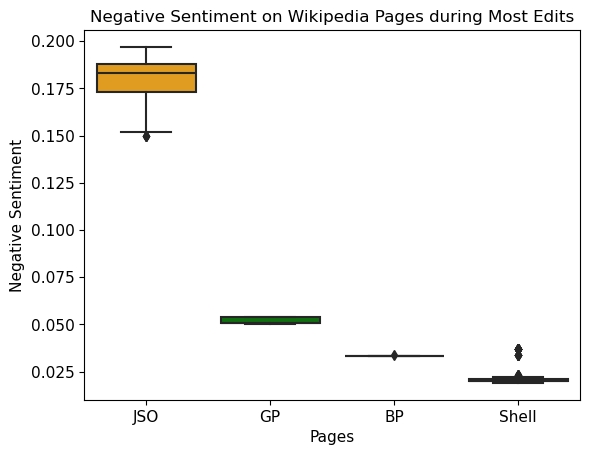

In [49]:
plot3()